# Introduction to Tensorflow and Tensorflow Probability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

## Useful utility functions

In [3]:
def plot_posterior_samples(ax, w_samples, data_x, data_y, data_ys, fill=False, title=None):
    '''
    Plot samples from a Bayesian linear regression.
    
    Args:
        ax:        Axis for plotting.
        w_samples: Samples from the posterior over regression parameters
        data_x:    Explanatory variables.
        data_y:    Responses.
        data_ys:   Uncertainty in data_y.
        fill:      Whether to fill area between the first and the last sample.
        title:     Plot title.
    '''
    ax.errorbar(data_x[:, 0], data_y[:, 0], data_ys, None, marker="o", ls='', capsize=5)
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('y', fontsize='xx-large')

    xmin, xmax = np.min(data_x[:, 0]), np.max(data_x[:, 0])
    X = np.array([[xmin, 1], [xmax, 1]])
    
    Y = X @ tf.transpose(w_samples)
    Y = tf.transpose(Y)
    for y in Y:
        ax.plot(X[:, 0], y, marker='', lw=1.0, alpha=0.5, color='r');
    
    if fill:
        plt.fill_between(X[:, 0], Y[0, :], Y[-1, :], alpha=0.3)
    
    if title is not None:
        ax.set_title(title, fontsize='x-large')

## Regression data

In this lab we will return to the linear regression example from Lab 3.

Let's prepare this data - our setup is the same as in Lab3, except this time we will use TensorFlow (TF) and TensorFlow Probability (TFP).

In [4]:
# D.W. Hogg et al. Data analysis recipes: Fitting a model to data, https://arxiv.org/abs/1008.4686, 2010
hogg_data = np.array([[201, 592, 61],
                      [244, 401, 25],
                      [47, 583, 38],
                      [287, 402, 15],
                      [203, 495, 21],
                      [58, 173, 15],
                      [210, 479, 27],
                      [202, 504, 14],
                      [198, 510, 30],
                      [158, 416, 16],
                      [165, 393, 14],
                      [201, 442, 25],
                      [157, 317, 52],
                      [131, 311, 16],
                      [166, 400, 34],
                      [160, 337, 31],
                      [186, 423, 42],
                      [125, 334, 26],
                      [218, 533, 16],
                      [146, 344, 22]], dtype=np.float32)

In [5]:
hogg_x_npy, hogg_y_npy, hogg_ys_npy = hogg_data[:, 0], hogg_data[:, 1], hogg_data[:, 2]

hogg_x_npy, hogg_y_npy = hogg_x_npy[:, None], hogg_y_npy[:, None]

ones = np.ones((hogg_x_npy.shape[0], 1))
hogg_x_npy = np.concatenate((hogg_x_npy, ones), axis=1)

Surprisingly, TensorFlow works with tensors :)

So we will encapsulate our input data in constant tensors.

In [6]:
hogg_x = tf.constant(hogg_x_npy, dtype=tf.float32)
hogg_y = tf.constant(hogg_y_npy, dtype=tf.float32)
hogg_ys = tf.constant(hogg_ys_npy, dtype=tf.float32)

2022-06-20 22:27:25.249432: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
hogg_x[:10]

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[201.,   1.],
       [244.,   1.],
       [ 47.,   1.],
       [287.,   1.],
       [203.,   1.],
       [ 58.,   1.],
       [210.,   1.],
       [202.,   1.],
       [198.,   1.],
       [158.,   1.]], dtype=float32)>

Now, let's plot this data.

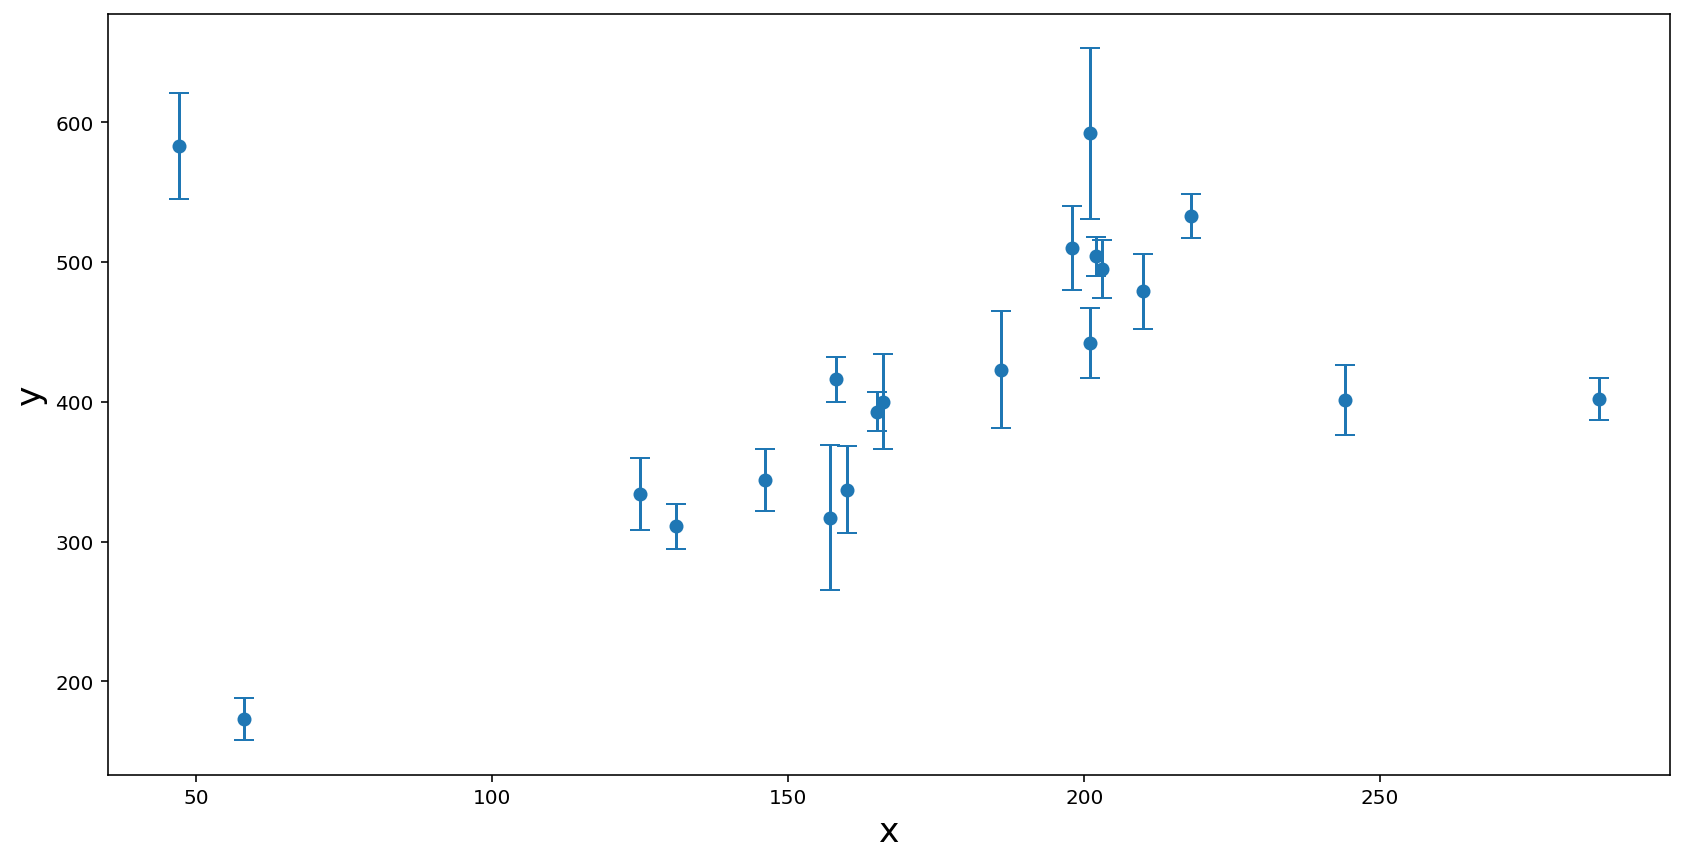

In [8]:
fig = plt.figure(figsize=(14, 7))
plt.errorbar(hogg_x[:, 0], hogg_y[:, 0], hogg_ys, None, marker="o", ls='', capsize=5)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('y', fontsize='xx-large');

As you can see, functions that expects NumPy arrays works without issues with TF tensors. There are implicit conversions between NumPy arrays and TF tensors.

## Bayesian linear regression

Let's go back to our Bayesian linear regression model. Our goal now is to implement `bayes_lin_reg` in TensorFlow. So this time we assume that all input arguments are TF tensors and we expect to return posterior parameters as TF tensors.

There are several useful hints to know:
- Basic math operators (+, -, *, /, @) are overloaded and will work with tensors.
- Linear algebra is provided by `tf.linalg` package.
- TF tensors do not implement a transpose property. So if `X` is a TF tensor then `X.T` construction won't work. You must use `tf.transpose(X)` instead.

---

Implement `bayes_lin_reg` function, which:
- takes as an input:
    - prior mean and covariance of the regression parameters $\mathbf{w}$,
    - response uncertainty ($\sigma$ hyperparameter),
    - matrix of explanatory variables and vector of responses,
- and returns parameters of the posterior distribution over $\mathbf{w}$ (mean and covariance).

In [9]:
def bayes_lin_reg(prior_mu, prior_Sigma, sigma, X, y):
    Sigma_n = tf.linalg.inv(tf.linalg.inv(prior_Sigma) + 1/(sigma * sigma) * tf.transpose(X) @ X)
    mu_n = Sigma_n @ (1/(sigma * sigma) * tf.transpose(X) @ y + tf.linalg.inv(prior_Sigma) @ prior_mu)
    return mu_n, Sigma_n

Now that we have `bayes_lin_reg` implemented, we can move to the prior for $\mathbf{w}$. We will use the same prior as in Lab 3.

In [10]:
y_mean, y_var = np.mean(hogg_y[:, 0]), np.var(hogg_y[:, 0])

mu_0 = np.array([0, y_mean]).reshape(-1, 1)
Sigma_0 = np.array([[1, 0],
                    [0, y_var]])

But remember that we work with tensors now. Prior parameters do not change, so we can make them constant tensors.

In [11]:
y_mean, y_var = tf.constant(y_mean, dtype=tf.float32), tf.constant(y_var, dtype=tf.float32)
mu_0, Sigma_0 = tf.constant(mu_0, dtype=tf.float32), tf.constant(Sigma_0, dtype=tf.float32)

Let's calculate the posterior parameters (assuming $\sigma=25$) and see if our implementation works.

In [12]:
sigma = 25.

mu_n, Sigma_n = bayes_lin_reg(mu_0, Sigma_0, sigma, hogg_x, hogg_y)
mu_n = tf.squeeze(mu_n)

We will now generate 50 samples from this posterior. This time however we will not use `SciPy`. We will instead work with TensorFlow Probability distributions. There are many distributions in TFP, including several variants of the Multivariate Normal. For example, there is a class for MVN with diagonal covariance and another class for MVN with full covariance. Obviously, we need the full covariance MVN.

In [13]:
posterior = tfd.MultivariateNormalFullCovariance(mu_n, Sigma_n)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Every TFP distribution has a `sample` method that generates samples.

In [14]:
w_samples_1 = posterior.sample(sample_shape = 50, seed=1234)

Let's plot these samples.

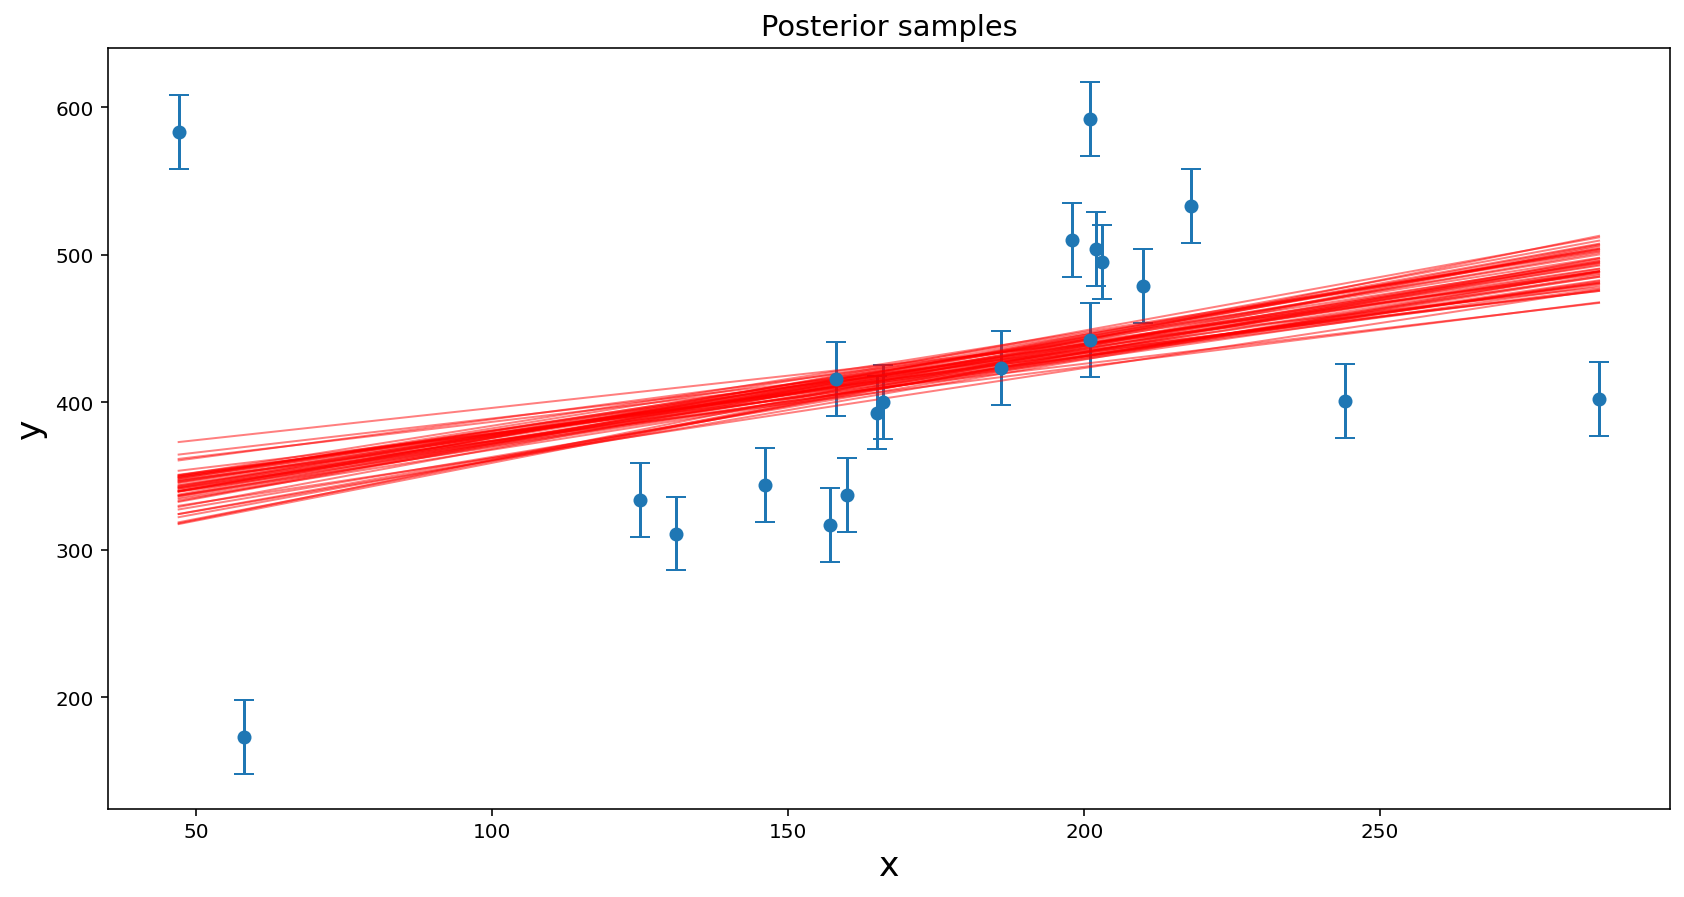

In [15]:
fig = plt.figure(figsize=(14, 7))
plot_posterior_samples(plt.gca(), w_samples_1, hogg_x, hogg_y, sigma, title='Posterior samples')

## Importance Sampling for Bayesian linear regression model

Our Bayesian linear regression model assumes we know the standard deviation of responses (i.e. $\sigma$). This is a significant limitation. We will now use Importance Sampling to gain an insight into the posterior of a more complex Bayesian linear regression model.

To begin with, we will put a prior on $\sigma$. Our model will therefore be:

$$\large
\begin{aligned}
  \sigma & \sim \mathrm{HalfCauchy}\left(\mathrm{loc} = 0,\ \mathrm{scale} = 10\right) \\
  \mathbf{w} & \sim N \left(\boldsymbol \mu_0, \mathbf{\Sigma}_0 \right) \\
  y \mid \mathbf{x}, \mathbf{w}, \mathbf{\sigma} & \sim
    N \left(\mathbf{w}^\mathsf{T}\mathbf{x}, \sigma^2 \right)
\end{aligned}
$$

---

Let's plot this prior for $\sigma$. Every TFP distribution implements a `prob` method that returns probability densities.

In [16]:
halfCauchy = tfd.HalfCauchy(loc=0., scale=10.)
x_range = np.arange(0, 100, 1.)
halfCauchy_pdf = halfCauchy.prob(x_range)

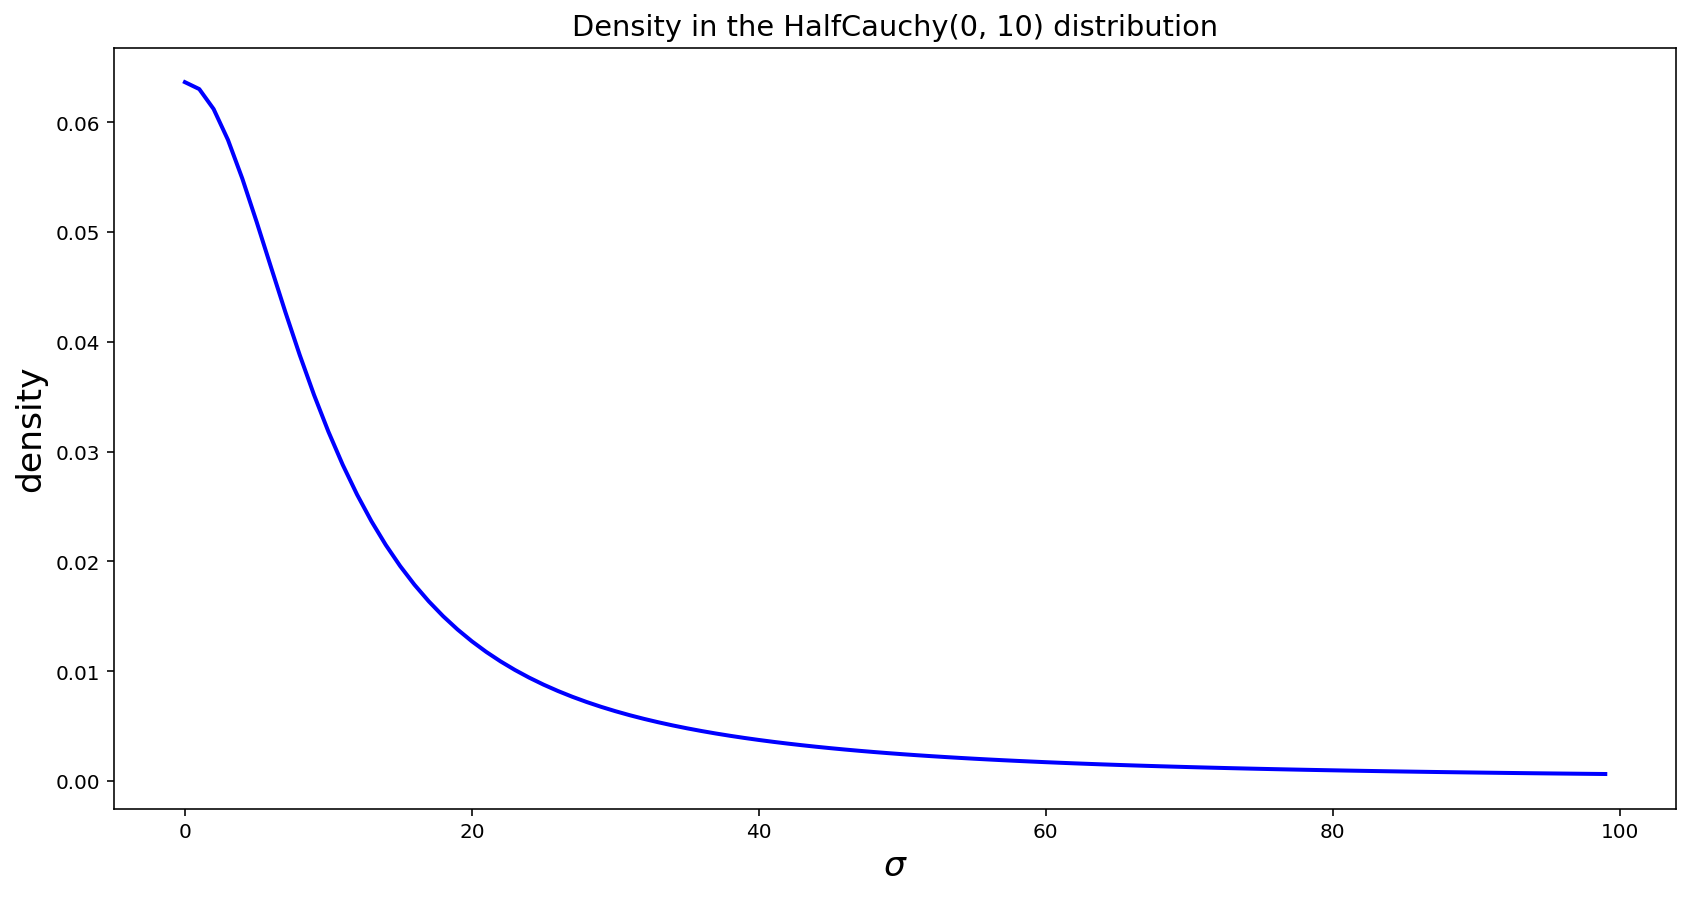

In [17]:
fig = plt.figure(figsize=(14, 7))
plt.plot(x_range, halfCauchy_pdf, marker='', lw=2.0, color='b')
plt.xlabel(r'$\sigma$', fontsize='xx-large')
plt.ylabel('density', fontsize='xx-large')
plt.title('Density in the HalfCauchy(0, 10) distribution', fontsize='x-large');

---

Now, let's got back to Importance Sampling. From the lecture we know that IS estimate is given by:

$$\large
\begin{aligned}
  \mathbb{E}\left[ f(\mathbf{x}) \right] & \approx \frac{Z_q}{Z_p} \frac{1}{n} \sum_{i=1}^n
    \frac{\widetilde{p}(\mathbf{x}_i)}{\widetilde{q}(\mathbf{x}_i)} f(\mathbf{x}_i) \\
  \frac{Z_p}{Z_q} & \approx \frac{1}{n} \sum_{i=1}^n
    \frac{\widetilde{p}(\mathbf{x}_i)}{\widetilde{q}(\mathbf{x}_i)}
\end{aligned}
$$

Combined, this gives:

$$\large
  \mathbb{E}\left[ f(\mathbf{x}) \right] \approx \sum_{i=1}^n \lambda_i f(\mathbf{x}_i)
$$

where the weights are:

$$\large
  \lambda_i = \frac{\widetilde{p}(\mathbf{x}_i)\ /\ \widetilde{q}(\mathbf{x}_i)}
                   {\sum_{j=1}^n \widetilde{p}(\mathbf{x}_j)\ /\ \widetilde{q}(\mathbf{x}_j)}
$$

---

Naive calculation of IS weights would fail due to numerical precision. Probabilities can be very small numbers - imagine $p(D \mid \mathbf{w}, \sigma)$ for a large dataset D! We will instead work in logarithmic domain:

$$\large
  s_i := \log \frac{\widetilde{p}(\mathbf{x}_i)}{\widetilde{q}(\mathbf{x}_i)}
       = \log \widetilde{p}(\mathbf{x}_i) - \log \widetilde{q}(\mathbf{x}_i)
$$

Now the weights will be:

$$\large
  \lambda_i = \frac{\mathrm{e}^{s_i}}{\sum_{j=1}^n \mathrm{e}^{s_j}}
$$

Note that this is equation for the softmax function! We know how to implement softmax in a numerically stable manner - we did such implementation in the last lab.

---

Implement `IS_weights` function which:
- takes as an input:
    - target log-densities (`logp`) with shape: `n_samples`,
    - proposal log-densities (`logq`) with shape: `n_samples`,
- and returns importance weights.

Hint: you may need `tf.reduce_max`, `tf.reduce_sum` and `tf.math.exp` functions.

In [18]:
def IS_weights(logp, logq):
    s = logp - logq
    s = s - tf.reduce_max(s)
    exp_s = tf.math.exp(s)
    return exp_s / tf.reduce_sum(exp_s)

Importance weights allow us to calculate mean and standard deviation of $f(\mathbf{x})$ with respect to the target probability distribution $p(\mathbf{x})$.

In [19]:
def IS_mean_std(f, logp, logq):
    '''
    Calculate mean and standard devation of f(x) with respect to p(x).
    
    Args:
        f:    Values of f(x), shape: n_samples.
        logp: Target log-densities, shape: n_samples.
        logq: Proosal log-densities: shape: n_samples.
        
    Returns:
        Mean and standard deviation of f with respect to the target density.
    '''
    weights = IS_weights(logp, logq)
    
    if len(f.shape) == 2:
        weights = tf.reshape(weights, [-1, 1])
    
    f_mean = tf.reduce_sum(weights * f, axis=0)
    f_var = tf.math.pow(f - f_mean, 2)
    f_var = tf.reduce_sum(weights * f_var, axis=0)
    
    return f_mean.numpy(), tf.math.sqrt(f_var).numpy()

Obviously, we need to define the priors for our linear regression model.

In [20]:
prior_sigma = tfd.HalfCauchy(loc=0, scale=10)
prior_w = tfd.MultivariateNormalFullCovariance(tf.squeeze(mu_0), Sigma_0)

We also need a proposal distribution and samples from it. We will adopt the prior as the proposal distribution. This should be ok if the target distribution (posterior) is similar to the prior.

In [21]:
proposal_sigma = prior_sigma
proposal_w = prior_w

In [22]:
n_samples = 10000

sigma_samples = proposal_sigma.sample(sample_shape = n_samples, seed=1234)
w_samples = proposal_w.sample(sample_shape = n_samples, seed=1234)

---

Finally, to make the above machinery work we need to calculate log-densities. Let's begin with the target log-density. From the Bayes equation we know that the posterior in our Bayesian linear regression model is:

$$ \large
p \left(\mathbf{w}, \sigma \mid D\right) =
  \frac{1}{Z_p} p\left(D \mid \mathbf{w}, \sigma\right) p(\mathbf{w}) p(\sigma)
$$

We need to calculate the posterior log-density up to the normalizing constant:

$$ \large
\log \widetilde{p} \left(\mathbf{w}, \sigma \mid D\right) =
  \log p\left(D \mid \mathbf{w}, \sigma\right) + \log p(\mathbf{w}) + \log p(\sigma)
$$

Let's begin with the log-likelihood: $\log p\left(D \mid \mathbf{w}, \sigma\right)$. Complete the implementation of `log_likelihood` function following comments in the code.

In [23]:
def log_likelihood(X, Y, w_samples, sigma_samples):
    '''
    Calculate log-likelihood for each sample in (w_samples, sigma_samples)
    
    Args:
        X:  Explanatory variables, shape n_data_points times 2.
        Y:  Responses, shape n_data_points times 1.
        w_samples:     Weight samples, shape n_samples times 2.
        sigma_samples: Sigma samples, shape n_samples times 1.
    '''
    
    # First we calculate w^T @ x for every sample w and every
    # data point x. The output is stored in Z. This tensor
    # should have the shape: n_samples times n_data_points.
    X, Y = tf.transpose(X), tf.transpose(Y)
    Z = w_samples @ X
    
    # Now we make sure that sigma samples have shape n_samples times 1
    sigma_samples = tf.reshape(sigma_samples, [-1, 1])
    
    # Now we need to create a batch of Gaussian distributions.
    # There should be n_samples times n_data_points distributions,
    # i.e. one for every sample in (w_samples, sigma_samples) and
    # every data point in (X, Y).
    #
    # Means are stored in Z. Standard deviations are in sigma_samples.
    #
    
    density = tfd.Normal(Z, sigma_samples)
    
    # We can now calculate log-densities for our data.
    
    logd = density.log_prob(Y)
    
    # Finally, we need to calculate log-likelihood for each sample
    # in (w_samples, sigma_samples)

    ll = tf.reduce_sum(logd, axis=1)
    
    return ll

Now that we have log-likelihood implemented, we can easily calculate posterior log-densities (up to the normalizing constant). Calculation of proposal log-densities is even simpler.

Complete the code below to calculate log-densities (`logp` and `logq`).

In [24]:
logp = log_likelihood(hogg_x, hogg_y, w_samples, sigma_samples) + prior_w.log_prob(w_samples) + prior_sigma.prob(sigma_samples)
logq = prior_w.log_prob(w_samples) + prior_sigma.prob(sigma_samples)

After these many-many steps we  (hopefully) have a working Importance Sampling for a Bayesian linear regression model with unknown $\sigma$. Let's calculate mean and standard deviation for each parameter.

First, noise level:

In [25]:
sigma_mean, sigma_std = IS_mean_std(sigma_samples, logp, logq)
print(f'sigma: {sigma_mean:.4} +- {sigma_std:.3}')

sigma: 97.24 +- 17.4


And then regression parameters - we will plot one standard-deviation band together with the data (and estimated noise level).

In [26]:
w_mean, w_std = IS_mean_std(w_samples, logp, logq)

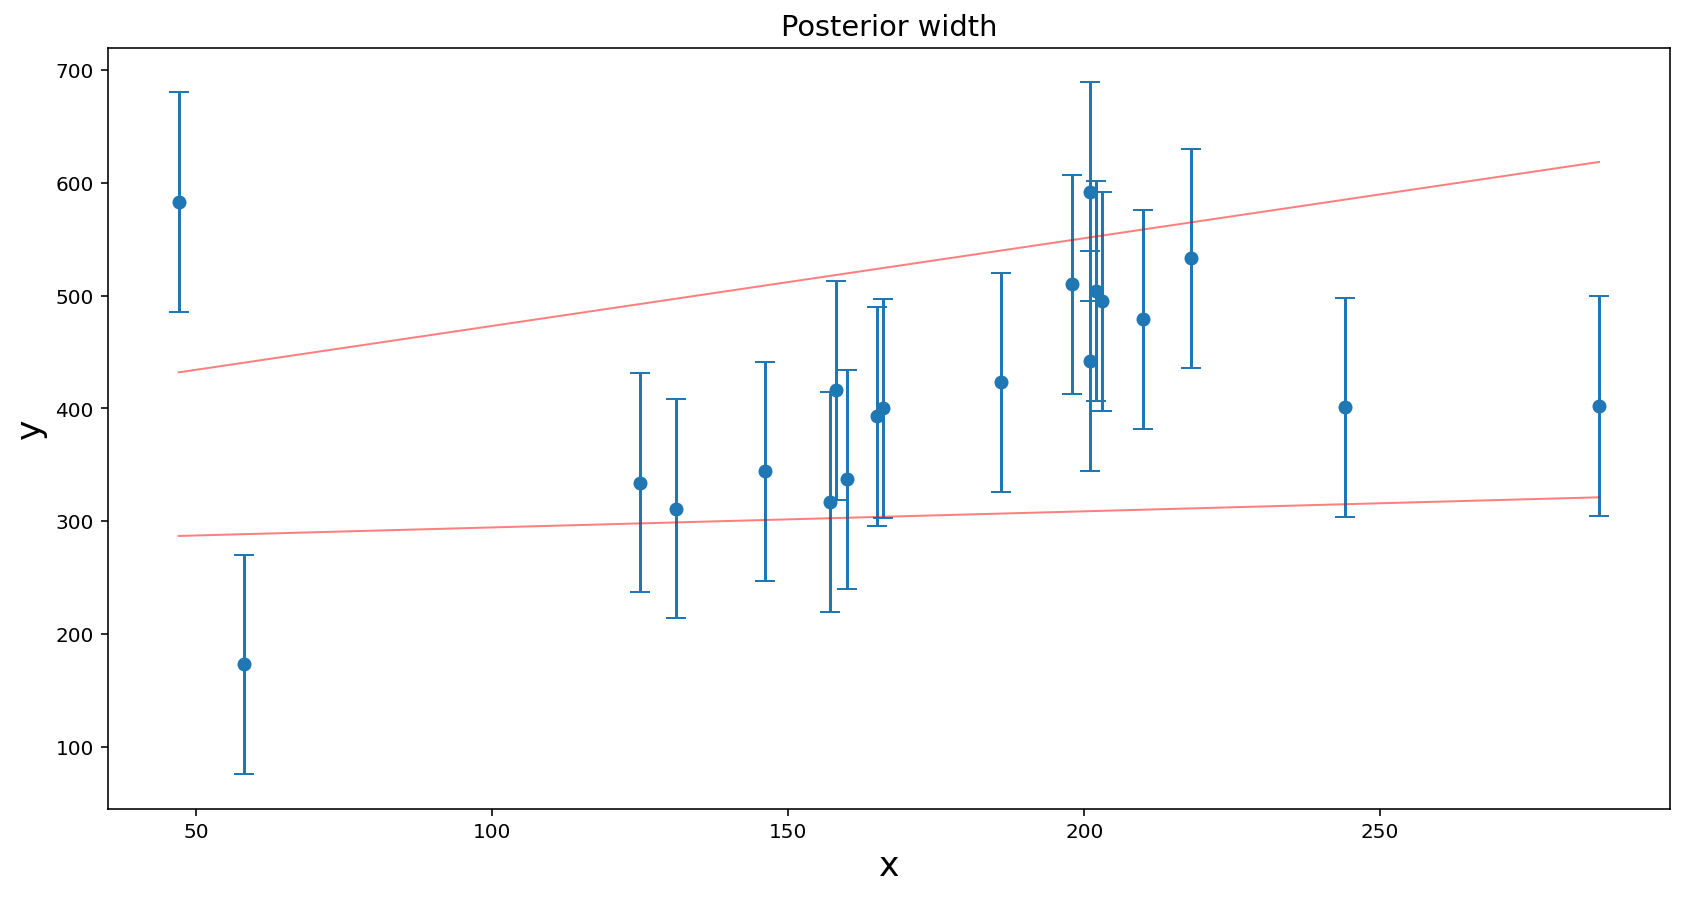

In [27]:
w_span = np.array([w_mean + w_std,
                   w_mean - w_std])

fig = plt.figure(figsize=(14, 7))
plot_posterior_samples(plt.gca(), w_span, hogg_x, hogg_y, sigma_mean, title='Posterior width')